In [42]:
from ldfi_py.pbool import *
import ldfi_py.pilp
import ldfi_py.psat
from parsing import ZipkinParser
import sys, re, os
from IPython.display import Image


In [43]:
# put this into a library later, or borrow tuan's function

def get_label_3(data):
    svcarr = data[9].split(":")[1].split("-")
    svcarr.pop()
    return "-".join(svcarr)

def get_label_2(data):
    return data[9].split(":")[1]

def get_label_1(data):
    return data[9]

def get_label(data):
    return get_label_1(data)

def get_bucket(trace):
    data = trace.root_annotations()[4]
    p = re.compile("http\.url;([^,]+)")
    m = p.search(data)
    if  m is not None:
        return m.group(1)
    else:
        return "??"

def get_formula(traces):
    outerset = set()
    for trace in traces:
        outerset.add(frozenset(trace.services()))

    conjuncts = None
    for inner in outerset:
        disjunction = None
        for item in inner:
            if disjunction is None:
                disjunction = Literal(item)
            else:
                disjunction = OrFormula(Literal(item), disjunction)
        if conjuncts is None:
            conjuncts = disjunction
        else:
            conjuncts = AndFormula(disjunction, conjuncts)
    return conjuncts
     



In [44]:
trace_file = '1st_half_jan_26'

buckets = {}
parser = ZipkinParser(trace_file, get_label)
for trace in parser.traces():
    if trace.sanity():
        # get bucket -- for now, Tuan says http.url
        bucket = get_bucket(trace)
        if bucket not in buckets:
            buckets[bucket] = set()
        buckets[bucket].add(trace)

In [45]:
limit = 0
for trace in parser.traces():
    for n in trace.spans.values():
        print n.data[9]
        limit += 1
        if limit > 15:
            sys.exit(1)

api-gateway:api-gateway-4025834462-lphbg:org.apache.http.impl.client.closeablehttpclient.execute
dao-service:dao-service-1547218744-xphqb:org.apache.catalina.core.standardhostvalve.invoke
user-service:user-service-4169250386-h9flq:sun.net.www.protocol.http.httpurlconnection.getinputstream
api-gateway:api-gateway-4025834462-lphbg:org.springframework.web.servlet.frameworkservlet.dopost
api-gateway:api-gateway-4025834462-lphbg:org.apache.catalina.core.standardhostvalve.invoke
user-service:user-service-4169250386-h9flq:org.springframework.web.servlet.frameworkservlet.dopost
dao-service:dao-service-1547218744-xphqb:com.mysql.jdbc.connectionimpl.preparestatement
api-gateway:api-gateway-4025834462-lphbg:com.netflix.hystrix.hystrixcommand.queue
dao-service:dao-service-1547218744-xphqb:com.mysql.jdbc.nonregisteringdriver.connect
dao-service:dao-service-1547218744-xphqb:com.huawei.cloud.mysql.dbmanager.printtable
dao-service:dao-service-1547218744-xphqb:com.huawei.cloud.mysql.dbmanager.printtabl

SystemExit: 1

/usr/local/Cellar/ipython@5/5.4.1_1/libexec/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [40]:
for key in buckets:
    print "KEY " + key + " -- " + str(len(buckets[key]))

#key = "http://127.0.0.1:8081/atswebsite/website"
key = "http://api-gateway:8080/product/product/buy/34211223411"

    

KEY http://127.0.0.1:8081/atswebsite/website -- 349
KEY http://10.154.72.17:30000/images/Huawei%20Air.png -- 1
KEY http://10.154.72.17:30000/js/acmeair-common.js -- 1
KEY http://api-gateway:8080/product/product/searchAll -- 2954
KEY http://api-gateway:8080/user/user/login -- 200
KEY http://localhost:8080/product/product/buy/34211223411 -- 1
KEY http://api-gateway:8080/product/product/buy/34211223411 -- 501


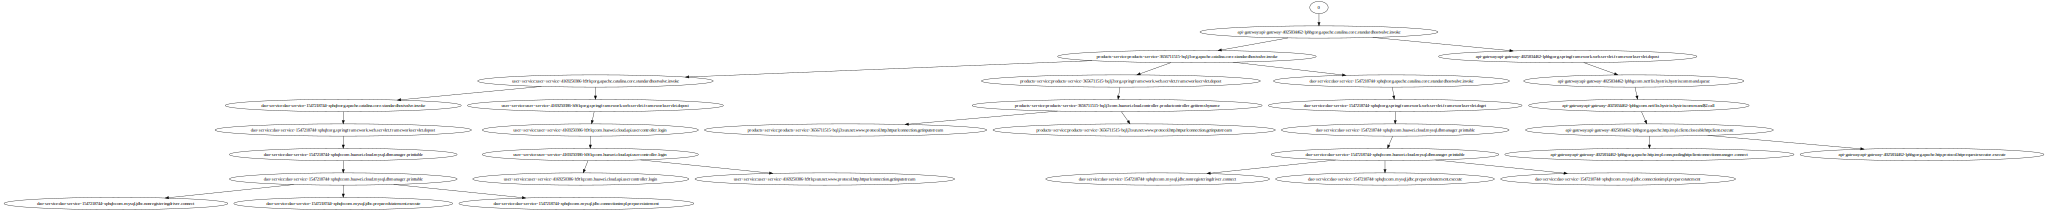

In [41]:
list(buckets[key])[0].to_dot()


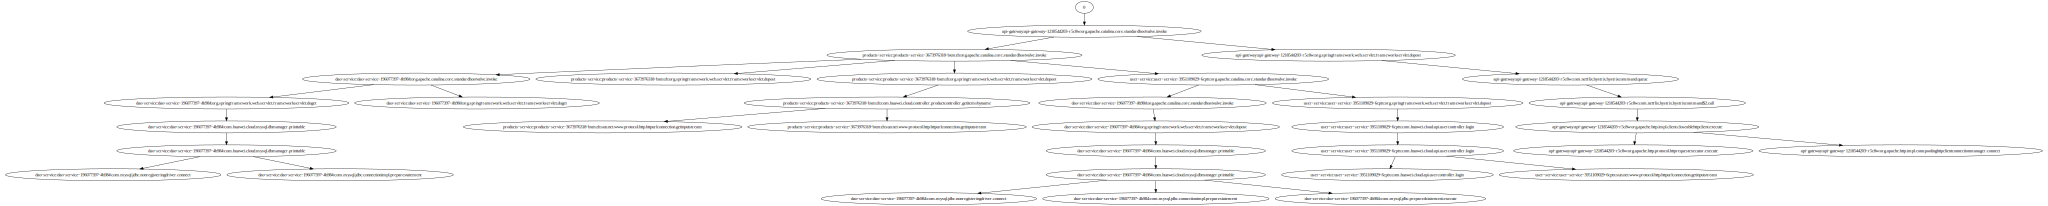

In [30]:
list(buckets[key])[1].to_dot()

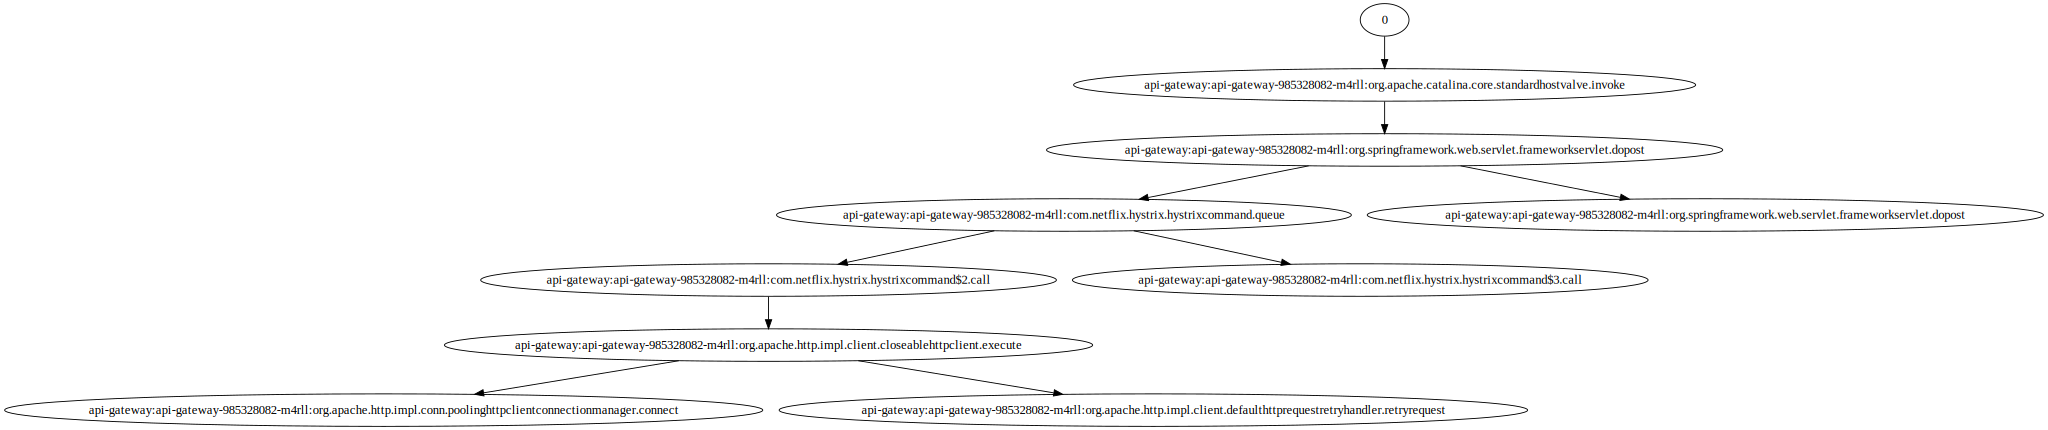

In [31]:
list(buckets[key])[100].to_dot()

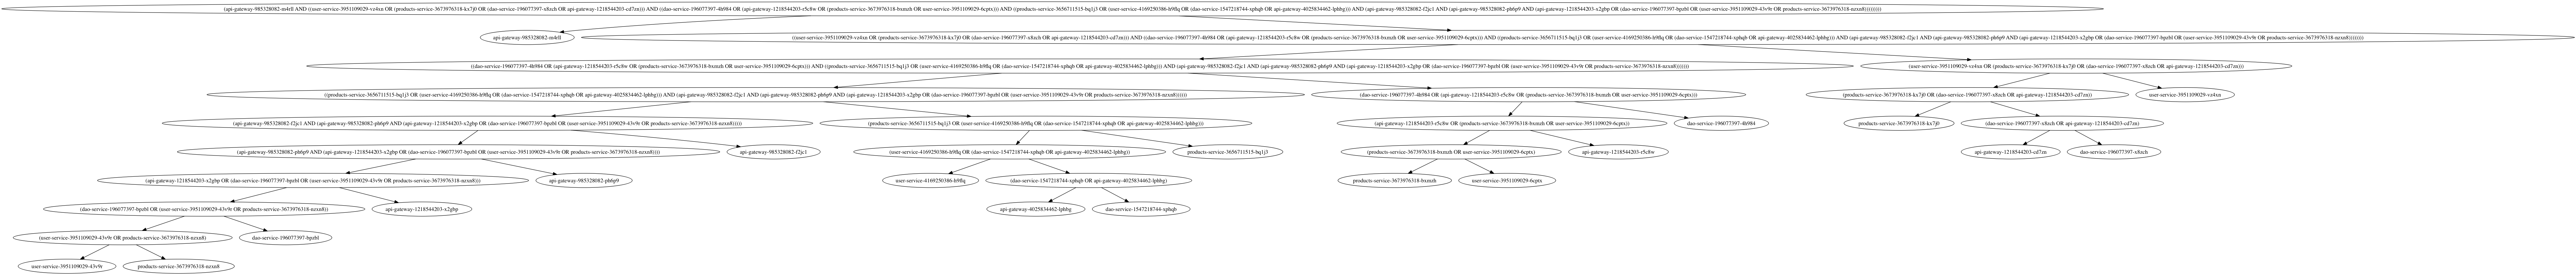

In [32]:
formula = get_formula(buckets[key])

formula.graph("foo.gv")
Image(filename='foo.gv.png')

In [33]:
cnf = CNFFormula(formula)

for c in cnf.conjuncts():
    print "Con: " + str(list(c))

s = ldfi_py.pilp.Solver(cnf)
    #s = ldfi_py.psat.Solver(cnf)

    #soln = next(s.solutions())
    #print "SOLN is " + str(soln)
#crs = list(s.solutions())
crs = s.solutions()



Con: ['api-gateway:api-gateway-985328082-f2jc1:com.netflix.hystrix.hystrixcommand$2.call', 'api-gateway:api-gateway-985328082-f2jc1:com.netflix.hystrix.hystrixcommand.queue', 'api-gateway:api-gateway-985328082-f2jc1:org.apache.http.impl.client.defaulthttprequestretryhandler.retryrequest', 'api-gateway:api-gateway-985328082-f2jc1:org.springframework.web.servlet.frameworkservlet.dopost', 'api-gateway:api-gateway-985328082-f2jc1:org.apache.http.impl.conn.poolinghttpclientconnectionmanager.connect', 'api-gateway:api-gateway-985328082-f2jc1:org.apache.http.impl.client.closeablehttpclient.execute', 'api-gateway:api-gateway-985328082-f2jc1:com.netflix.hystrix.hystrixcommand$3.call', 'api-gateway:api-gateway-985328082-f2jc1:org.apache.catalina.core.standardhostvalve.invoke']
Con: ['api-gateway:api-gateway-1218544203-r5c8w:com.netflix.hystrix.hystrixcommand$2.call', 'products-service:products-service-3673976318-bxmzh:sun.net.www.protocol.http.httpurlconnection.getinputstream', 'products-service

In [34]:
crs.next()

[api_gateway:api_gateway_985328082_ph6p9:org.apache.http.impl.client.closeablehttpclient.execute,
 api_gateway:api_gateway_985328082_m4rll:com.netflix.hystrix.hystrixcommand$2.call,
 products_service:products_service_3656711515_bq1j3:sun.net.www.protocol.http.httpurlconnection.getinputstream,
 products_service:products_service_3673976318_bxmzh:com.huawei.cloud.controller.productcontroller.getitemsbyname,
 user_service:user_service_3951109029_43v9r:sun.net.www.protocol.http.httpurlconnection.getinputstream,
 api_gateway:api_gateway_1218544203_cd7zn:org.apache.catalina.core.standardhostvalve.invoke,
 api_gateway:api_gateway_985328082_f2jc1:com.netflix.hystrix.hystrixcommand$2.call]

In [35]:
crs.next()

[products_service:products_service_3673976318_bxmzh:org.apache.catalina.core.standardhostvalve.invoke,
 api_gateway:api_gateway_985328082_m4rll:com.netflix.hystrix.hystrixcommand$2.call,
 api_gateway:api_gateway_985328082_f2jc1:com.netflix.hystrix.hystrixcommand$3.call,
 api_gateway:api_gateway_1218544203_cd7zn:org.springframework.web.servlet.frameworkservlet.dopost,
 products_service:products_service_3656711515_bq1j3:sun.net.www.protocol.http.httpurlconnection.getinputstream,
 user_service:user_service_3951109029_43v9r:sun.net.www.protocol.http.httpurlconnection.getinputstream,
 api_gateway:api_gateway_985328082_ph6p9:com.netflix.hystrix.hystrixcommand.queue]

In [21]:
crs.next()

[user_service_3951109029_6cptx,
 api_gateway_985328082_ph6p9,
 dao_service_196077397_x8zch,
 api_gateway_985328082_f2jc1,
 api_gateway_1218544203_x2gbp,
 products_service_3656711515_bq1j3,
 api_gateway_985328082_m4rll]

In [22]:
crs.next()

[api_gateway_985328082_ph6p9,
 dao_service_196077397_x8zch,
 api_gateway_985328082_f2jc1,
 products_service_3673976318_nzxn8,
 api_gateway_985328082_m4rll,
 api_gateway_1218544203_r5c8w,
 dao_service_1547218744_xphqb]

In [23]:
crs.next()

[api_gateway_985328082_ph6p9,
 api_gateway_985328082_f2jc1,
 user_service_3951109029_vz4xn,
 user_service_4169250386_h9flq,
 api_gateway_985328082_m4rll,
 api_gateway_1218544203_r5c8w,
 dao_service_196077397_bpzbl]

In [37]:
for 

SyntaxError: invalid syntax (<ipython-input-37-6555b14f4657>, line 1)

In [42]:
limit = 0
for trace in parser.traces():
    for n in trace.spans.values():
        print n.data[9]
        limit += 1
        if limit > 100:
            break

api-gateway:api-gateway-4025834462-lphbg:org.apache.http.impl.client.closeablehttpclient.execute
dao-service:dao-service-1547218744-xphqb:org.apache.catalina.core.standardhostvalve.invoke
user-service:user-service-4169250386-h9flq:sun.net.www.protocol.http.httpurlconnection.getinputstream
api-gateway:api-gateway-4025834462-lphbg:org.springframework.web.servlet.frameworkservlet.dopost
api-gateway:api-gateway-4025834462-lphbg:org.apache.catalina.core.standardhostvalve.invoke
user-service:user-service-4169250386-h9flq:org.springframework.web.servlet.frameworkservlet.dopost
dao-service:dao-service-1547218744-xphqb:com.mysql.jdbc.connectionimpl.preparestatement
api-gateway:api-gateway-4025834462-lphbg:com.netflix.hystrix.hystrixcommand.queue
dao-service:dao-service-1547218744-xphqb:com.mysql.jdbc.nonregisteringdriver.connect
dao-service:dao-service-1547218744-xphqb:com.huawei.cloud.mysql.dbmanager.printtable
dao-service:dao-service-1547218744-xphqb:com.huawei.cloud.mysql.dbmanager.printtabl

dao-service:dao-service-1547218744-xphqb:org.springframework.web.servlet.frameworkservlet.doget
api-gateway:api-gateway-985328082-f2jc1:com.netflix.hystrix.hystrixcommand$2.call
api-gateway:api-gateway-985328082-f2jc1:org.apache.http.impl.client.defaulthttprequestretryhandler.retryrequest
api-gateway:api-gateway-985328082-f2jc1:org.apache.http.impl.client.defaulthttprequestretryhandler.retryrequest
api-gateway:api-gateway-985328082-f2jc1:org.springframework.web.servlet.frameworkservlet.doget
dao-service:dao-service-196077397-bpzbl:com.mysql.jdbc.connectionimpl.preparestatement
dao-service:dao-service-1547218744-xphqb:org.apache.catalina.core.standardhostvalve.invoke
api-gateway:api-gateway-985328082-f2jc1:com.netflix.hystrix.hystrixcommand$2.call
testats:testats-1428155099-f53nk:org.apache.catalina.core.standardhostvalve.invoke
api-gateway:api-gateway-985328082-ph6p9:org.springframework.web.servlet.frameworkservlet.doget
api-gateway:api-gateway-985328082-ph6p9:com.netflix.hystrix.hystr

api-gateway:api-gateway-985328082-ph6p9:com.netflix.hystrix.hystrixcommand$2.call
user-service:user-service-4169250386-h9flq:com.huawei.cloud.api.usercontroller.login
api-gateway:api-gateway-985328082-f2jc1:org.apache.catalina.core.standardhostvalve.invoke
api-gateway:api-gateway-985328082-f2jc1:com.netflix.hystrix.hystrixcommand.queue
products-service:products-service-3656711515-bq1j3:org.apache.catalina.core.standardhostvalve.invoke
api-gateway:api-gateway-985328082-ph6p9:org.springframework.web.servlet.frameworkservlet.doget
api-gateway:api-gateway-985328082-ph6p9:com.netflix.hystrix.hystrixcommand$3.call
api-gateway:api-gateway-985328082-ph6p9:com.netflix.hystrix.hystrixcommand.queue
user-service:user-service-614740664-wf0rl:com.huawei.cloud.api.usercontroller.login
api-gateway:api-gateway-985328082-m4rll:org.apache.catalina.core.standardhostvalve.invoke
ams-0119:ams-0119-2401493085-2bwqq:sun.net.www.protocol.http.httpurlconnection.getinputstream
ats-demo:ats-demo-3974871235-xq5lx: